# Quora Questions on GPU

The goal of this project is to identify insincere questions in a dataset of around 1 300 000 questions from Quora. The questions are about various topics and vary in length.

This is a short notebook to try the code from the main notebook on GPU.

In [2]:
## Imports
import tensorflow
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import pickle
import string
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.preprocessing.sequence as sq


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams.update({'font.size': 25})

from IPython.display import clear_output

## 1. Data exploration

There are over 1 300 000 sentences in the dataset.

We are going to use the GloVe 300 embedding from Common Crawl [1].

In [92]:
# Load data and embedding
path_in = './data/'

train = pd.read_csv(path_in + 'train.csv')
#train = train[0:300000]

### 1.1 Example sentences

The sentences are in `question_text` and the label is in `target`, where `1` is a positive (insincere) and `0`a negative. Here is an example sentence along with the label:

In [4]:
print("Example sentence: \"{}\"\nLabel: {}".format(train['question_text'][8], train['target'][8]))

Example sentence: "Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?"
Label: 0


Let's see how many positives and negatives we have in the data:

In [5]:
print("Ratio of positives to total: {:.2f}%".format(len(train.loc[train['target'] == 1])*100 / len(train)))

Ratio of positives to total: 6.19%


That means our model can achieve an accuracy of 95% purley by guessing. This shows that the accuracy score is not a good metric to quanitify a model when having strongly unbalanced data [2]. 

### 2.2 The easy way - Keras tokenizer

We now split the dataset into train, validation and testing. We also utilize the PyTorch Datalaoder functions to simplify batching.

In [93]:
# Build the tokenizer dictionary in the tokenizer class
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train['question_text'])

# Split train set into train and validation sets
train, validation = train_test_split(train, test_size=0.1, shuffle = True)
train.reset_index(inplace=True)
validation.reset_index(inplace=True)

# Tokenize the questions
train_sequences = tokenizer.texts_to_sequences(train['question_text'])
validation_sequences = tokenizer.texts_to_sequences(validation['question_text'])

# Save the tokenizer dictionary and the number of words in it
word_index = tokenizer.word_index
vocab_size = len(word_index)

First we tokenize all words in the data using the `Tokenizer` from the Keras library. Note that we filter out the characters given to the `filters` attribute.

Next, we split the data into training and validation data.

Finally, using the tokens defined in the first step, we can tokenize the indivdual sentences from the questions. That way, we get a vector for each sentence. Here, the length is the number of words, exlcuding the characters in the filter.

**Output:**

`word_index`Dictionary of word and assigned number (token)

`vocab_size` Int number of words in vocabulary

TODO:
* Merge similar words together
* Include punctuation

In [94]:
## Pad sequences with 0s so that each sequence is of the same length respresented by the max_length
max_length = 50
padding_type = 'pre'
trunc_type = 'pre'

train_sequences_padded = sq.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences_padded = sq.pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [95]:
## Convert data to tensors
training_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(train_sequences_padded)), torch.FloatTensor(np.array(train['target'])))
validation_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(validation_sequences_padded)), torch.FloatTensor(np.array(validation['target'])))

In the dataset for training, we now have an array of length 50 with tokens for each sentence.

### 2.3 Embedding
We use the GloVe 300 ... embedding. It was trained on ??. We want to get a tensor which includes the 300 dimensional weights for all words in our vocabulary. This `embedding_matrix` is used later by the embedding layer.

In [96]:
def load_embedding(embedding_File, embedding_dim, vocab_size, word_index):
    print('Loading word embeddings...')
    embedding_index = {}
    with open(embedding_File,'r', encoding = 'utf8') as f:
        for line in f:
            values = line.split();
            word = ''.join(values[:-1*embedding_dim]);
            coefs = np.asarray(values[-1*embedding_dim:], dtype='float32');
            embedding_index[word] = coefs;

    embedding_matrix = np.zeros((vocab_size+1, embedding_dim));
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word);
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector;  
            
    print('Finished loading word embeddings. {:.0f} words loaded.'.format(len(embedding_matrix)))
    return embedding_matrix

## Load embedding
embedding_dim = 300
embedding_File = './data/GloVe300d.txt'

embedding_matrix = load_embedding(embedding_File, embedding_dim, vocab_size, word_index)
weights = torch.FloatTensor(embedding_matrix)

Loading word embeddings...
Finished loading word embeddings. 222162 words loaded.


## 3. Prediction

### 3.1 Net
The net has an embedding layer which feeds into the LSTM layer. The LSTM is connected to a linear layer.

For the LSTM layer we want a many-to-one architecture. That means we want to feed in the sequence (whole sentence) and get one output.

The LSTM layer has the outputs `lstm_out, (h_n, c_n)`. To get the many-to-one output, you can either take the last element of the sequence `lstm_out`, or `h_n` which is the same. For more info see the documentation [https://pytorch.org/docs/stable/nn.html#lstm].

In [97]:
class Net(nn.Module):
    def __init__(self, seq_length, hidden_layer_1, hidden_layer_2):
        super(Net, self).__init__()
        
        ## Embedding layer
        self.embd = nn.Embedding.from_pretrained(weights)
        
        ## LSTM
        self.lstm = nn.LSTM(input_size=len(weights[0,:]), hidden_size=hidden_layer_1, batch_first=True)
        
        ## Linear layer
        self.fc1 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_2, 1)
        self.relu2 = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, x):
        embd_out = self.embd(x)         
        lstm_out, (h_out, _) = self.lstm(embd_out)
        x = self.relu1(self.fc1(h_out))
        x = self.relu2(self.fc2(x))
        x = self.out(x)
        
        return x

### 3.2 Train the net

In [88]:
if torch.cuda.is_available():
    cuda = torch.device('cuda')
    print("Cuda available")
    
    ## Convert data to CUDA objects
    training_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(train_sequences_padded)).to('cuda'), torch.FloatTensor(np.array(train['target'])).to('cuda'))
    validation_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(validation_sequences_padded)).to('cuda'), torch.FloatTensor(np.array(validation['target'])).to('cuda')) 
    weights = weights.to('cuda')

Cuda available


In [89]:
torch.cuda.empty_cache()

In [99]:
### Function for training
epochs = 20
learning_rate = 0.001
momentum = 0.9

seq_length = 50
hidden_layer_1 = 100
hidden_layer_2 = 100

batch_size = 10000


## Define dataloader
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Initialize net and define loss function and optimizer
model = Net(seq_length, hidden_layer_1, hidden_layer_2).cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

##### Iterate through the data
loss_acc = {'Loss': [], 'Train accuracy': [], 'Validation accuracy':[]}
#model.train() 
for epoch in range(epochs):
    print("Epoch {} / {}".format(epoch+1, epochs))
      
    train_correct = 0    
      
    for x, y in train_loader:
        # Set gradients to zero
        optimizer.zero_grad()
        
        # Forward pass
        y_hat = model(x)
        
        # Evaluate output / compute loss
        y_hat = y_hat.view(-1) 
        loss = criterion(y_hat, y)       
        
        # Backward pass / optimize
        loss.backward()
        
        # Update weights
        optimizer.step()        
        
        with torch.no_grad():
            y_hat = y_hat.detach().cpu().clone().numpy()
            y = y.detach().cpu().clone().numpy()
            
            ## Evaluate train result
            y_hat = np.where(y_hat > 0.5, 1, 0)
            train_correct += (y_hat == y).sum()
            loss_acc['Loss'].append(loss.item())
        
    #model.eval()
    val_correct = 0    
    for x, y in validation_loader:
        y_hat = model(x)
        
        
        ## Evaluate validation result
        with torch.no_grad():
            y_hat.squeeze_()
            y_hat = y_hat.detach().cpu().clone().numpy()
            y = y.detach().cpu().clone().numpy()
          
            y_hat = np.where(y_hat > 0.5, 1, 0)
            val_correct += (y_hat == y).sum()
            
    
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(validation_loader.dataset)
    
    loss_acc['Train accuracy'].append(train_acc)
    loss_acc['Validation accuracy'].append(val_acc)
    
    print("Loss: {:.4f}".format(loss_acc['Loss'][-1]))
    print("Training accuracy: {:.4f} | Validation accuracy: {:.4f}".format(loss_acc['Train accuracy'][-1], loss_acc['Validation accuracy'][-1]))

## Save trained model
torch.save(model.state_dict(), "./results/model.p")
    
print("\nTraining completed!")

Epoch 1 / 20
Loss: 0.6931
Training accuracy: 0.94 | Validation accuracy: 0.94
Epoch 2 / 20
Loss: 0.6931
Training accuracy: 0.94 | Validation accuracy: 0.94
Epoch 3 / 20


KeyboardInterrupt: 

In [ ]:
print(torch.cuda.memory_allocated() / 1e9)

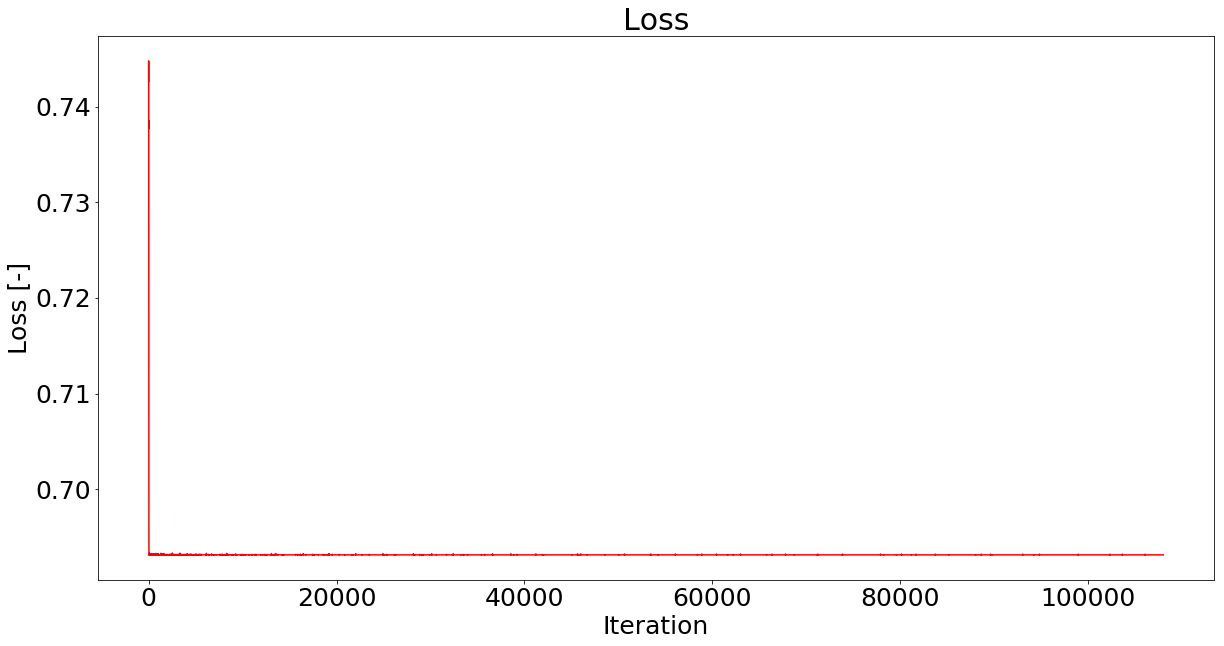

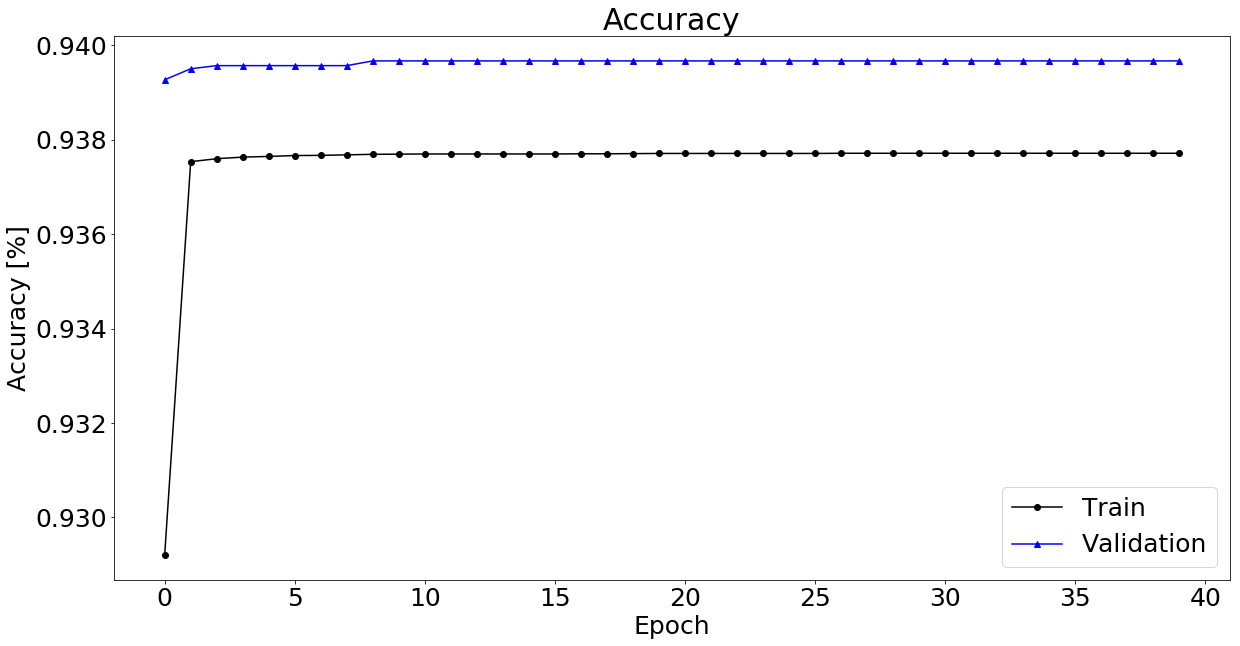

In [91]:
## Plots
fig = plt.figure(1)
plt.plot(loss_acc['Loss'], color="red")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")
plt.savefig("./results/Plot_loss.pdf")


fig = plt.figure(2)
plt.plot(loss_acc['Train accuracy'], "o-", color="black", label="Train")
plt.plot(loss_acc['Validation accuracy'], "^-",color="blue", label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.ylabel("Accuracy [%]")
plt.savefig("./results/Plot_accuracy.pdf")

## 4. Evaluation

In [ ]:
## Use trained model for validation
net.eval()

#torch.save(net.state_dict(), './classifier/Classifier-.pt')

x, y = Variable(testing_data), Variable(torch.from_numpy(np.array(testing_labels)), requires_grad=False)

pred = net(x)
predicted_labels = np.where(pred > 0.5, 1, 0)

accuracy_score(np.array(testing_labels["RESULT"]), predicted_labels)

In [ ]:
def Compute_Metrics():
    ## Precision
    # r = t_p / (t_p + f_p)
    precision = precision_score(testing_labels, predicted_labels)
    print("Precision: {}".format(precision))
    
    ## Recall
    # r = t_p / (t_p + f_n)
    recall = recall_score(testing_labels, predicted_labels)
    print("Recall: {}".format(recall))
    
    ## F1 Score
    f1 = f1_score(testing_labels, predicted_labels)
    print("F1 Score: {}".format(f1))
    
    return precision, recall, f1

precision, recall, f1 = Compute_Metrics()

In [ ]:
## Confusion matrix
def Confusion_Matrix(con_mat):
    
    plt.title("Confusion Matrix", fontsize=50)
    sn.set(font_scale=2.5)
    sn.heatmap(con_mat, annot=True, fmt='g', annot_kws={"size":30}, xticklabels=["OK", "NOK"], yticklabels=["OK", "NOK"], 
               cmap="YlGnBu")
    plt.xlabel("Prediction", fontsize=40)
    plt.ylabel("Truth", fontsize=40)

    
con_mat = confusion_matrix(testing_labels, predicted_labels)
Confusion_Matrix(con_mat)

## References
[1] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. *GloVe: Global Vectors for Word Representation*. 2014.

[2] Han, Kamber, Pei. *Data Mining: Concepts and Techniques*. 2011